In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
import do_mpc
import pandas as pd
from sklearn import linear_model

In [28]:
res = do_mpc.data.load_results('./results/kite.pkl')

phi = res['simulator']['_x', 'phi'].flatten()
theta = res['simulator']['_x', 'theta'].flatten()
u_tilde = res['simulator']['_u', 'u_tilde'].flatten()
psi = res['simulator']['_x', 'psi'].flatten()
E_0 = res['simulator']['_p', 'E_0'].flatten()
v_0 = res['simulator']['_p', 'v_0'].flatten()


nn_input = {'phi':phi, 'theta': theta, 'u_tilde': u_tilde}
nn_output = {'phi':phi, 'theta': theta, 'psi': psi,  'u_tilde': u_tilde, 'E_0': E_0, 'v_0': v_0}

nn_input_df = pd.DataFrame.from_dict(nn_input)
nn_output_df = pd.DataFrame.from_dict(nn_output)

nn_input_list = [nn_input_df]
nn_output_list = [nn_output_df]

## RNN I/O structure
All our recurrent neural networks are trained with the stateful setting **True**. The settings is explained [here](https://keras.io/examples/lstm_stateful/). In summary, after having trained on a given data sequence, we use the resulting hidden state to initialize the next sequence. This is beneficial, when a very long coherent sequence is chopped into chunks for training (due to memory restrictions). In practice this allows to train the network to incoroporate much older information than the horizon, as defined with `seq_length`, contains. 

The downside of stateful training is, that data pre-processing is becoming more complex, when using batches. 
In the code cell below, we are preparing the data for stateful training with `batch_size > 0`.

In [29]:
X = nn_input_df.to_numpy()
Y = nn_output_df.to_numpy()
nx = X.shape[1]
ny = Y.shape[1]

# Create DNN:

In [23]:
n_layer = 4          # This includes the output layer. n_layer-1 is the number of hidden layers.
n_units = 70         # Number of units per hidden layer.  
l1_regularizer = 0

model_param = {}
model_param['n_in'] = nx
model_param['n_out'] = ny
model_param['n_units'] = (n_layer)*[n_units]
model_param['activation'] = (n_layer) * ['tanh']

inputs = keras.Input(shape=(model_param['n_in'],))

layer_list = [inputs]


for i in range(len(model_param['n_units'])-1):
    layer_list.append(
        keras.layers.Dense(model_param['n_units'][i],
                           activation=model_param['activation'][i],
                           kernel_regularizer=keras.regularizers.l1(l=l1_regularizer)
                           )(layer_list[i])
    )

outputs = keras.layers.Dense(model_param['n_out'],
                             activation='linear')(layer_list[-1])

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss='mse', optimizer='Adam')

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 70)                280       
_________________________________________________________________
dense_5 (Dense)              (None, 70)                4970      
_________________________________________________________________
dense_6 (Dense)              (None, 70)                4970      
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 426       
Total params: 10,646
Trainable params: 10,646
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(X, 
                    Y, 
                    batch_size=100, 
                    epochs=1000)

Train on 1500 samples
Epoch 1/1000
1500/1500 [==============================] - 0s 205us/sample - loss: 11.3404
Epoch 2/1000
1500/1500 [==============================] - 0s 19us/sample - loss: 7.6836
Epoch 3/1000
1500/1500 [==============================] - 0s 41us/sample - loss: 3.1383
Epoch 4/1000
1500/1500 [==============================] - 0s 39us/sample - loss: 0.7488
Epoch 5/1000
1500/1500 [==============================] - 0s 62us/sample - loss: 0.5581
Epoch 6/1000
1500/1500 [==============================] - 0s 35us/sample - loss: 0.5039
Epoch 7/1000
1500/1500 [==============================] - 0s 36us/sample - loss: 0.4627
Epoch 8/1000
1500/1500 [==============================] - 0s 28us/sample - loss: 0.4392
Epoch 9/1000
1500/1500 [==============================] - 0s 64us/sample - loss: 0.4172
Epoch 10/1000
1500/1500 [==============================] - 0s 40us/sample - loss: 0.3992
Epoch 11/1000
1500/1500 [==============================] - 0s 62us/sample - loss: 0.3826
Epoch 

1500/1500 [==============================] - 0s 18us/sample - loss: 0.0537
Epoch 93/1000
1500/1500 [==============================] - 0s 29us/sample - loss: 0.0527
Epoch 94/1000
1500/1500 [==============================] - 0s 21us/sample - loss: 0.0525
Epoch 95/1000
1500/1500 [==============================] - 0s 26us/sample - loss: 0.0532
Epoch 96/1000
1500/1500 [==============================] - 0s 27us/sample - loss: 0.0550
Epoch 97/1000
1500/1500 [==============================] - 0s 21us/sample - loss: 0.0543
Epoch 98/1000
1500/1500 [==============================] - 0s 22us/sample - loss: 0.0536
Epoch 99/1000
1500/1500 [==============================] - 0s 22us/sample - loss: 0.0521
Epoch 100/1000
1500/1500 [==============================] - 0s 22us/sample - loss: 0.0511
Epoch 101/1000
1500/1500 [==============================] - 0s 22us/sample - loss: 0.0505
Epoch 102/1000
1500/1500 [==============================] - 0s 30us/sample - loss: 0.0505
Epoch 103/1000
1500/1500 [======

1500/1500 [==============================] - 0s 22us/sample - loss: 0.0379
Epoch 184/1000
1500/1500 [==============================] - 0s 22us/sample - loss: 0.0362
Epoch 185/1000
1500/1500 [==============================] - 0s 22us/sample - loss: 0.0346
Epoch 186/1000
1500/1500 [==============================] - 0s 22us/sample - loss: 0.0354
Epoch 187/1000
1500/1500 [==============================] - 0s 22us/sample - loss: 0.0350
Epoch 188/1000
1500/1500 [==============================] - 0s 22us/sample - loss: 0.0373
Epoch 189/1000
1500/1500 [==============================] - 0s 22us/sample - loss: 0.0357
Epoch 190/1000
1500/1500 [==============================] - 0s 22us/sample - loss: 0.0359
Epoch 191/1000
1500/1500 [==============================] - 0s 23us/sample - loss: 0.0352
Epoch 192/1000
1500/1500 [==============================] - 0s 32us/sample - loss: 0.0355
Epoch 193/1000
1500/1500 [==============================] - 0s 34us/sample - loss: 0.0348
Epoch 194/1000
1500/1500 

1500/1500 [==============================] - 0s 44us/sample - loss: 0.0284
Epoch 275/1000
1500/1500 [==============================] - 0s 34us/sample - loss: 0.0277
Epoch 276/1000
1500/1500 [==============================] - 0s 45us/sample - loss: 0.0279
Epoch 277/1000
1500/1500 [==============================] - 0s 25us/sample - loss: 0.0276
Epoch 278/1000
1500/1500 [==============================] - 0s 29us/sample - loss: 0.0276
Epoch 279/1000
1500/1500 [==============================] - 0s 25us/sample - loss: 0.0289
Epoch 280/1000
1500/1500 [==============================] - 0s 32us/sample - loss: 0.0289
Epoch 281/1000
1500/1500 [==============================] - 0s 31us/sample - loss: 0.0281
Epoch 282/1000
1500/1500 [==============================] - 0s 35us/sample - loss: 0.0286
Epoch 283/1000
1500/1500 [==============================] - 0s 28us/sample - loss: 0.0297
Epoch 284/1000
1500/1500 [==============================] - 0s 24us/sample - loss: 0.0281
Epoch 285/1000
1500/1500 

1500/1500 [==============================] - 0s 25us/sample - loss: 0.0258
Epoch 366/1000
1500/1500 [==============================] - 0s 28us/sample - loss: 0.0246
Epoch 367/1000
1500/1500 [==============================] - 0s 15us/sample - loss: 0.0238
Epoch 368/1000
1500/1500 [==============================] - 0s 29us/sample - loss: 0.0249
Epoch 369/1000
1500/1500 [==============================] - 0s 17us/sample - loss: 0.0248
Epoch 370/1000
1500/1500 [==============================] - 0s 22us/sample - loss: 0.0243
Epoch 371/1000
1500/1500 [==============================] - 0s 19us/sample - loss: 0.0235
Epoch 372/1000
1500/1500 [==============================] - 0s 26us/sample - loss: 0.0240
Epoch 373/1000
1500/1500 [==============================] - 0s 13us/sample - loss: 0.0240
Epoch 374/1000
1500/1500 [==============================] - 0s 19us/sample - loss: 0.0242
Epoch 375/1000
1500/1500 [==============================] - 0s 19us/sample - loss: 0.0236
Epoch 376/1000
1500/1500 

Epoch 456/1000
1500/1500 [==============================] - 0s 25us/sample - loss: 0.0224
Epoch 457/1000
1500/1500 [==============================] - 0s 42us/sample - loss: 0.0229
Epoch 458/1000
1500/1500 [==============================] - 0s 17us/sample - loss: 0.0226
Epoch 459/1000
1500/1500 [==============================] - 0s 20us/sample - loss: 0.0224
Epoch 460/1000
1500/1500 [==============================] - 0s 37us/sample - loss: 0.0231
Epoch 461/1000
1500/1500 [==============================] - 0s 51us/sample - loss: 0.0224
Epoch 462/1000
1500/1500 [==============================] - 0s 53us/sample - loss: 0.0216
Epoch 463/1000
1500/1500 [==============================] - 0s 43us/sample - loss: 0.0216
Epoch 464/1000
1500/1500 [==============================] - 0s 55us/sample - loss: 0.0217
Epoch 465/1000
1500/1500 [==============================] - 0s 48us/sample - loss: 0.0209
Epoch 466/1000
1500/1500 [==============================] - 0s 55us/sample - loss: 0.0213
Epoch 467/

1500/1500 [==============================] - 0s 15us/sample - loss: 0.0188
Epoch 548/1000
1500/1500 [==============================] - 0s 27us/sample - loss: 0.0195
Epoch 549/1000
1500/1500 [==============================] - 0s 16us/sample - loss: 0.0202
Epoch 550/1000
1500/1500 [==============================] - 0s 16us/sample - loss: 0.0191
Epoch 551/1000
1500/1500 [==============================] - 0s 18us/sample - loss: 0.0201
Epoch 552/1000
1500/1500 [==============================] - 0s 18us/sample - loss: 0.0202
Epoch 553/1000
1500/1500 [==============================] - 0s 30us/sample - loss: 0.0197
Epoch 554/1000
1500/1500 [==============================] - 0s 66us/sample - loss: 0.0198
Epoch 555/1000
1500/1500 [==============================] - 0s 62us/sample - loss: 0.0204
Epoch 556/1000
1500/1500 [==============================] - 0s 34us/sample - loss: 0.0203
Epoch 557/1000
1500/1500 [==============================] - 0s 14us/sample - loss: 0.0193
Epoch 558/1000
1500/1500 

1500/1500 [==============================] - 0s 13us/sample - loss: 0.0184
Epoch 639/1000
1500/1500 [==============================] - 0s 14us/sample - loss: 0.0186
Epoch 640/1000
1500/1500 [==============================] - 0s 14us/sample - loss: 0.0181
Epoch 641/1000
1500/1500 [==============================] - 0s 13us/sample - loss: 0.0180
Epoch 642/1000
1500/1500 [==============================] - 0s 14us/sample - loss: 0.0187
Epoch 643/1000
1500/1500 [==============================] - 0s 13us/sample - loss: 0.0186
Epoch 644/1000
1500/1500 [==============================] - 0s 13us/sample - loss: 0.0178
Epoch 645/1000
1500/1500 [==============================] - 0s 12us/sample - loss: 0.0181
Epoch 646/1000
1500/1500 [==============================] - 0s 13us/sample - loss: 0.0191
Epoch 647/1000
1500/1500 [==============================] - 0s 12us/sample - loss: 0.0198
Epoch 648/1000
1500/1500 [==============================] - 0s 13us/sample - loss: 0.0182
Epoch 649/1000
1500/1500 

1500/1500 [==============================] - 0s 134us/sample - loss: 0.0179
Epoch 729/1000
1500/1500 [==============================] - 0s 75us/sample - loss: 0.0169
Epoch 730/1000
1500/1500 [==============================] - 0s 24us/sample - loss: 0.0164
Epoch 731/1000
1500/1500 [==============================] - 0s 28us/sample - loss: 0.0165
Epoch 732/1000
1500/1500 [==============================] - 0s 25us/sample - loss: 0.0167
Epoch 733/1000
1500/1500 [==============================] - 0s 36us/sample - loss: 0.0173
Epoch 734/1000
1500/1500 [==============================] - 0s 28us/sample - loss: 0.0174
Epoch 735/1000
1500/1500 [==============================] - 0s 22us/sample - loss: 0.0179
Epoch 736/1000
1500/1500 [==============================] - 0s 23us/sample - loss: 0.0169
Epoch 737/1000
1500/1500 [==============================] - 0s 31us/sample - loss: 0.0170
Epoch 738/1000
1500/1500 [==============================] - 0s 61us/sample - loss: 0.0167
Epoch 739/1000
1500/1500

1500/1500 [==============================] - 0s 14us/sample - loss: 0.0158
Epoch 820/1000
1500/1500 [==============================] - 0s 20us/sample - loss: 0.0156
Epoch 821/1000
1500/1500 [==============================] - 0s 23us/sample - loss: 0.0155
Epoch 822/1000
1500/1500 [==============================] - 0s 16us/sample - loss: 0.0160
Epoch 823/1000
1500/1500 [==============================] - 0s 16us/sample - loss: 0.0157
Epoch 824/1000
1500/1500 [==============================] - 0s 17us/sample - loss: 0.0156
Epoch 825/1000
1500/1500 [==============================] - 0s 17us/sample - loss: 0.0156
Epoch 826/1000
1500/1500 [==============================] - 0s 14us/sample - loss: 0.0157
Epoch 827/1000
1500/1500 [==============================] - 0s 15us/sample - loss: 0.0151
Epoch 828/1000
1500/1500 [==============================] - 0s 16us/sample - loss: 0.0156
Epoch 829/1000
1500/1500 [==============================] - 0s 13us/sample - loss: 0.0162
Epoch 830/1000
1500/1500 

1500/1500 [==============================] - 0s 18us/sample - loss: 0.0150
Epoch 911/1000
1500/1500 [==============================] - 0s 24us/sample - loss: 0.0157
Epoch 912/1000
1500/1500 [==============================] - 0s 63us/sample - loss: 0.0154
Epoch 913/1000
1500/1500 [==============================] - 0s 47us/sample - loss: 0.0139
Epoch 914/1000
1500/1500 [==============================] - 0s 75us/sample - loss: 0.0145
Epoch 915/1000
1500/1500 [==============================] - 0s 105us/sample - loss: 0.0139
Epoch 916/1000
1500/1500 [==============================] - 0s 94us/sample - loss: 0.0143
Epoch 917/1000
1500/1500 [==============================] - 0s 112us/sample - loss: 0.0142
Epoch 918/1000
1500/1500 [==============================] - 0s 104us/sample - loss: 0.0150
Epoch 919/1000
1500/1500 [==============================] - 0s 102us/sample - loss: 0.0142
Epoch 920/1000
1500/1500 [==============================] - 0s 92us/sample - loss: 0.0146
Epoch 921/1000
1500/1

# Evaluate Model


In [30]:
test_with = 0
nn_input_test = nn_input_list[test_with]


res = []

for i,in_i in nn_input_test.iterrows():
    nn_in = in_i.to_numpy()
    nn_out = model.predict(nn_in.reshape(1,-1))
    res.append(nn_out)
res = np.concatenate(res, axis=0).squeeze()

In [31]:
res_df = pd.DataFrame(res, columns = nn_output.keys())

Text(0, 0.5, 'v_0')

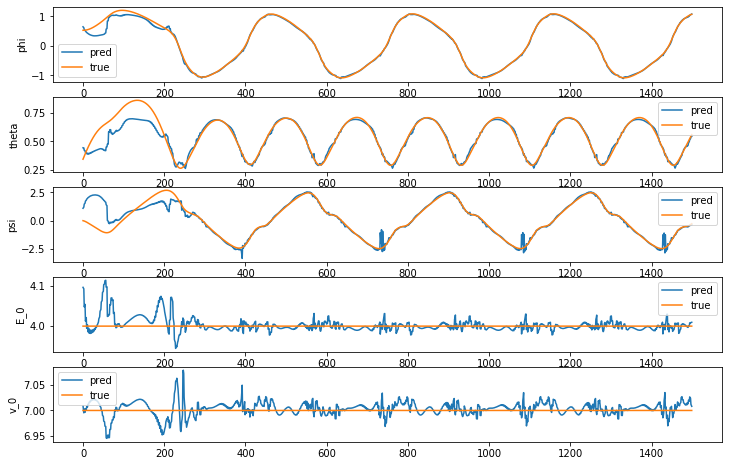

In [32]:
fig, ax = plt.subplots(5, figsize=(12,8))

res_df.plot(y=['phi'], ax=ax[0], label=['pred'])
nn_output_df.plot(y=['phi'], ax=ax[0], label=['true'])
ax[0].set_ylabel('phi')

res_df.plot(y=['theta'], ax=ax[1], label=['pred'])
nn_output_df.plot(y=['theta'], ax=ax[1], label=['true'])
ax[1].set_ylabel('theta')

res_df.plot(y=['psi'], ax=ax[2], label=['pred'])
nn_output_df.plot(y=['psi'], ax=ax[2], label=['true'])
ax[2].set_ylabel('psi')

res_df.plot(y=['E_0'], ax=ax[3], label=['pred'])
nn_output_df.plot(y=['E_0'], ax=ax[3], label=['true'])
ax[3].set_ylabel('E_0')

res_df.plot(y=['v_0'], ax=ax[4], label=['pred'])
nn_output_df.plot(y=['v_0'], ax=ax[4], label=['true'])
ax[4].set_ylabel('v_0')